In [1]:
import swiftemulator as se
from swiftemulator.design import latin
from swiftemulator.emulators import gaussian_process
from swiftemulator.emulators import multi_gaussian_process
from swiftemulator.mean_models.linear import LinearMeanModel
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.special import erf
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import matplotlib.patheffects as path_effects
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
import illustris_python as il
import pickle
from scipy.optimize import curve_fit

# Universal constants
c = 2.99792458e10          # Speed of light [cm/s]
kB = 1.380648813e-16       # Boltzmann's constant [g cm^2/s^2/K]
h = 6.626069573e-27        # Planck's constant [erg/s]
mH = 1.6735327e-24         # Mass of hydrogen atom [g]
me = 9.109382917e-28       # Electron mass [g]
ee = 4.80320451e-10        # Electron charge [g^(1/2) cm^(3/2) / s]

# Emperical unit definitions
Msun = 1.988435e33         # Solar mass [g]
Lsun = 3.839e33            # Solar luminosity [erg/s]
Zsun = 0.0134              # Solar metallicity (mass fraction)
arcsec = 648000. / np.pi   # arseconds per radian
pc = 3.085677581467192e18  # Units: 1 pc  = 3e18 cm
kpc = 1e3 * pc             # Units: 1 kpc = 3e21 cm
Mpc = 1e6 * pc             # Units: 1 Mpc = 3e24 cm
km = 1e5                   # Units: 1 km  = 1e5  cm
angstrom = 1e-8            # Units: 1 angstrom = 1e-8 cm
day = 86400.               # Units: 1 day = 24 * 3600 seconds
yr = 365.24 * day          # Units: 1 year = 365.24 days
kyr = 1e3 * yr             # Units: 1 Myr = 10^6 yr
Myr = 1e6 * yr             # Units: 1 Myr = 10^6 yr
lambda_1216 = 1215.67 * angstrom # Lyman-alpha wavelength [cm]
lambda_1500 = 1500. * angstrom # Continuum wavelength [cm]
lambda_2500 = 2500. * angstrom # Continuum wavelength [cm]
R_10pc = 10. * pc              # Reference distance for continuum [cm]
fnu_1216_fac = lambda_1216**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_1500_fac = lambda_1500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
fnu_2500_fac = lambda_2500**2 / (4. * np.pi * c * R_10pc**2 * angstrom)
E_AGN = 5.29e-11 # Mean photon energy [erg]
E_Lya = h * c / lambda_1216 # Lyman-alpha energy [erg]

In [2]:
model_specification = se.ModelSpecification(
    number_of_parameters=5,
    parameter_names=["log_Mhalo_min","log_Mhalo_max", "fesc_min", "a_mu", "b_mu"],
    parameter_limits=[[9.5,11.5],[10.5,12.],[0.05,0.4],[0.,2.],[1.,2.]],
    parameter_printable_names=["$M_{\\rm halo, min}$", "$M_{\\rm halo, max}$", "$f_{\\rm esc}$", "$\\mu_{\\rm c}$", "$\\mu_{\\rm o}$"],
)

In [3]:
modelparameters_file = open('/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/model_parameters_5d_5.5.obj', 'rb')
model_parameters = pickle.load(modelparameters_file)
modelparameters_file.close()

n_models = len(model_parameters)
print(n_models)

240


In [4]:
modelvalues = {}

for unique_identifier in model_parameters.model_parameters.keys():
    filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/5d_LF_test_emulators_5.5_new/LF_5d_s0_080_{unique_identifier}.hdf5'
    
    with h5py.File(filename, 'r') as f: 
        y_avg_obs = f['y_avg_obs'][:].astype(np.float64)
        y_phi_obs = f['y_phi_obs'][:].astype(np.float64)
        y_err_obs = f['y_err_obs'][:].astype(np.float64)

        mask = (y_avg_obs > 10**41.5) # Ignore faint objects
        y_avg_obs = y_avg_obs[mask]
        y_phi_obs = y_phi_obs[mask]
        y_err_obs = y_err_obs[mask]
        
        log_yavg = np.log10(y_avg_obs)
        log_yphi = np.log10(y_phi_obs)
        log_yerr = 0.5 * (np.log10(y_phi_obs + y_err_obs) - np.log10(y_phi_obs - y_err_obs))

    modelvalues[unique_identifier] = {"independent": log_yavg, "dependent": log_yphi, "dependent_error": log_yerr}

model_values = se.ModelValues(model_values=modelvalues)

print(len(model_values))
# print(model_values)

240


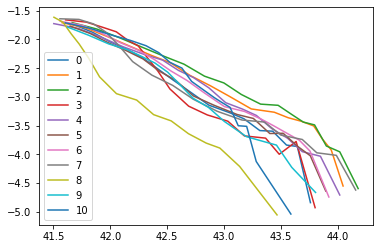

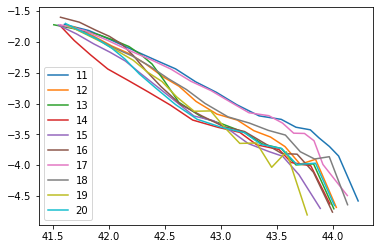

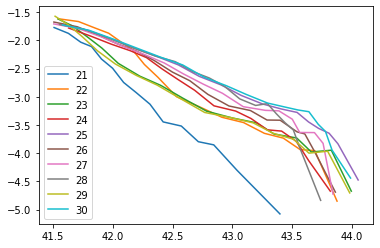

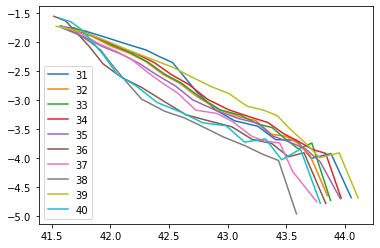

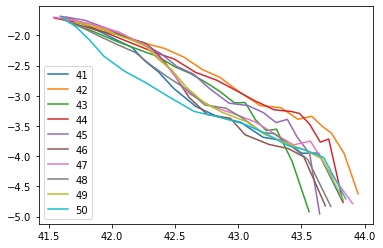

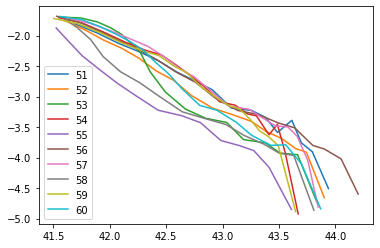

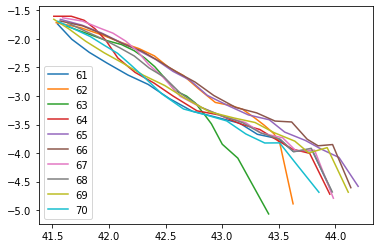

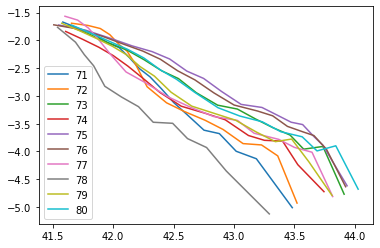

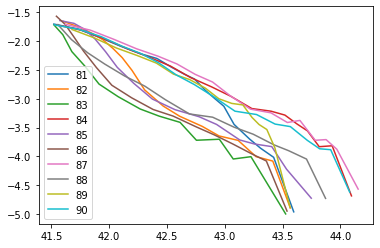

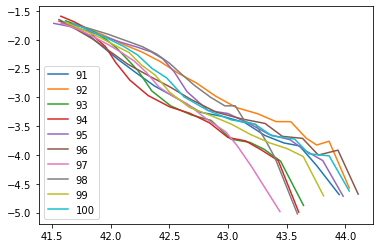

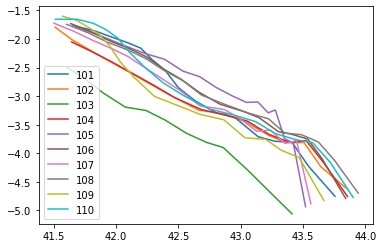

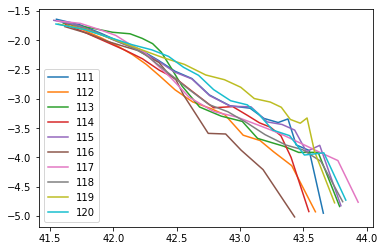

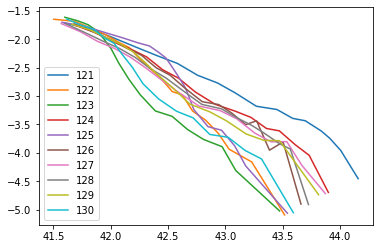

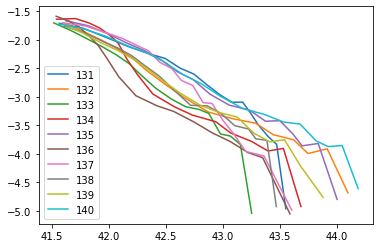

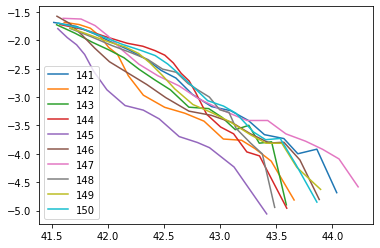

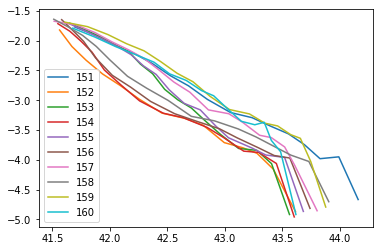

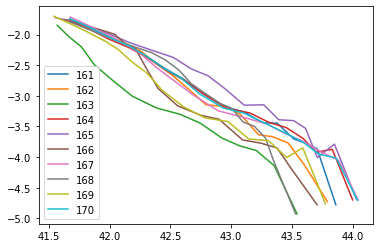

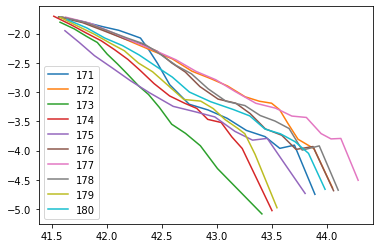

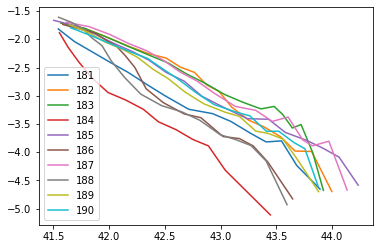

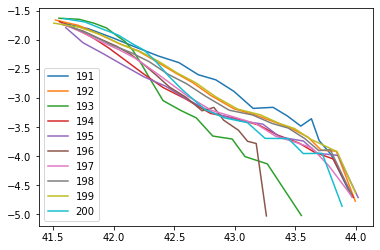

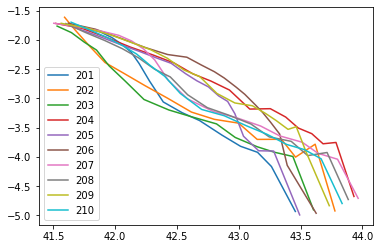

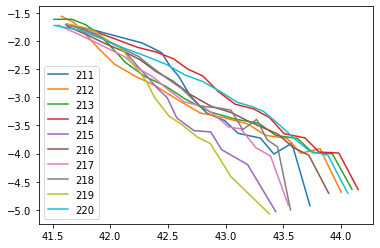

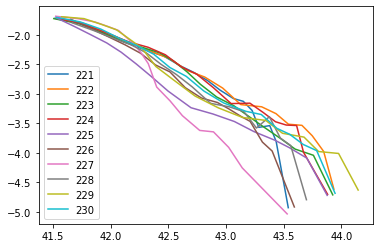

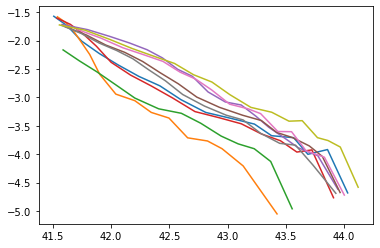

In [5]:
count = 0
for i in model_parameters.model_parameters.keys():
    mv = model_values[i]
    plt.plot(mv['independent'], mv['dependent'], label=i)
    if count % 10 == 0 and count > 1:
        plt.legend()
        plt.savefig(f'5d_figures_5.5_new/real_runs_{count/10}.png')
        plt.show()
    count += 1

### Regular emulator

In [8]:
linear_model = LinearMeanModel()

LF_emulator = gaussian_process.GaussianProcessEmulator(mean_model=linear_model)
LF_emulator.fit_model(model_specification=model_specification, model_parameters=model_parameters, model_values=model_values)


In [9]:
# pickle
LF_emulator_obj = open('LF_emulator_5d_5.5_new.obj', 'wb')
pickle.dump(LF_emulator, LF_emulator_obj)
LF_emulator_obj.close()

In [6]:
# unpickle
LF_emulator_obj = open('LF_emulator_5d_5.5_new.obj', 'rb')
LF_emulator = pickle.load(LF_emulator_obj)
LF_emulator_obj.close()

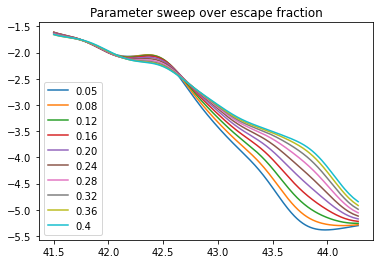

In [7]:
from swiftemulator.mocking import mock_sweep

center = {"log_Mhalo_min": 11, "log_Mhalo_max": 11.2, "fesc_min": 0.1, 'a_mu': 1.5, 'b_mu': 1.75}

Mock_values, Mock_parameters = mock_sweep(LF_emulator,model_specification,10,"fesc_min",center)

for mock_name in Mock_values.keys():
    plt.plot(Mock_values[mock_name]["independent"],
            Mock_values[mock_name]["dependent"],
            label = str(Mock_parameters[mock_name]["fesc_min"])[:4])

plt.legend()
plt.title('Parameter sweep over escape fraction')
plt.savefig("5d_figures_5.5_new/parameter_sweep_fesc.png",dpi=200)
plt.show()
# plt.savefig("parameter_sweep.png",dpi=200)

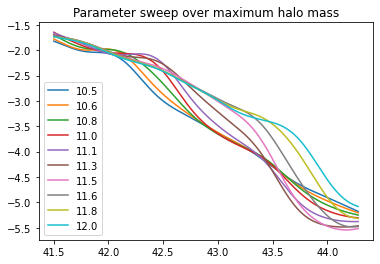

In [8]:
center = {"log_Mhalo_min": 11, "log_Mhalo_max": 11.2, "fesc_min": 0.1, 'a_mu': 1.5, 'b_mu': 1}

Mock_values, Mock_parameters = mock_sweep(LF_emulator,model_specification,10,"log_Mhalo_max",center)

for mock_name in Mock_values.keys():
#     mask = (np.sqrt(Mock_values[mock_name]['dependent_error']) < 0.1)
#     plt.errorbar(Mock_values[mock_name]["independent"],
#             Mock_values[mock_name]["dependent"],np.sqrt(Mock_values[mock_name]['dependent_error']),
#             label = str(Mock_parameters[mock_name]["log_Mhalo_max"])[:4])
    plt.plot(Mock_values[mock_name]["independent"],
            Mock_values[mock_name]["dependent"],
            label = str(Mock_parameters[mock_name]["log_Mhalo_max"])[:4])

plt.legend()
plt.title('Parameter sweep over maximum halo mass')
plt.savefig("5d_figures_5.5_new/parameter_sweep_max_mass.png",dpi=200)
plt.show()
# plt.savefig("parameter_sweep.png",dpi=200)

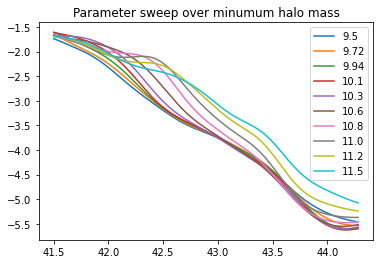

In [9]:
center = {"log_Mhalo_min": 11, "log_Mhalo_max": 11.2, "fesc_min": 0.1, 'a_mu': 1.5, 'b_mu': 1}

Mock_values, Mock_parameters = mock_sweep(LF_emulator,model_specification,10,"log_Mhalo_min",center)

for mock_name in Mock_values.keys():
    plt.plot(Mock_values[mock_name]["independent"],
            Mock_values[mock_name]["dependent"],
            label = str(Mock_parameters[mock_name]["log_Mhalo_min"])[:4])

plt.legend()
plt.title('Parameter sweep over minumum halo mass')
plt.savefig("5d_figures_5.5_new/parameter_sweep_min_mass.png",dpi=200)
plt.show()
# plt.savefig("parameter_sweep.png",dpi=200)

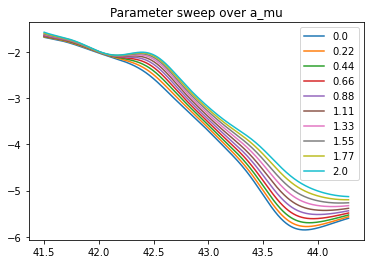

In [10]:
center = {"log_Mhalo_min": 11, "log_Mhalo_max": 11.2, "fesc_min": 0.1, 'a_mu': 1.5, 'b_mu': 1.75}

Mock_values, Mock_parameters = mock_sweep(LF_emulator,model_specification,10,"a_mu",center)

for mock_name in Mock_values.keys():
    plt.plot(Mock_values[mock_name]["independent"],
            Mock_values[mock_name]["dependent"],
            label = str(Mock_parameters[mock_name]["a_mu"])[:4])

plt.legend()
plt.title('Parameter sweep over a_mu')
plt.savefig("5d_figures_5.5_new/parameter_sweep_a_mu.png",dpi=200)
plt.show()

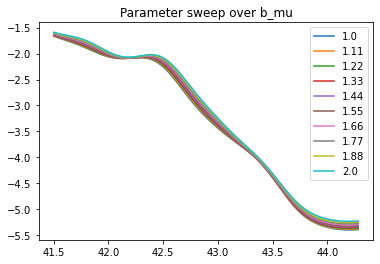

In [11]:
center = {"log_Mhalo_min": 11, "log_Mhalo_max": 11.2, "fesc_min": 0.1, 'a_mu': 1.5, 'b_mu': 1.75}

Mock_values, Mock_parameters = mock_sweep(LF_emulator,model_specification,10,"b_mu",center)

for mock_name in Mock_values.keys():
    plt.plot(Mock_values[mock_name]["independent"],
            Mock_values[mock_name]["dependent"],
            label = str(Mock_parameters[mock_name]["b_mu"])[:4])

plt.legend()
plt.title('Parameter sweep over b_mu')
plt.savefig("5d_figures_5.5_new/parameter_sweep_b_mu.png",dpi=200)
plt.show()

### Cross checks for regular GP emulator - didn't rerun on expanded dataset

In [7]:
# reducing no. of models to 50
n_models_crosschecks = 50
modelparameters = {}

first = np.zeros(n_models_crosschecks)
for i in range(n_models_crosschecks):
    first[i] = list(model_parameters.model_parameters.keys())[i]
print(first)
    
for j in range(n_models_crosschecks):
    i = first[j]
    mp = model_parameters[i]
    modelparameters[i] = {"log_Mhalo_min": mp['log_Mhalo_min'],
                        "log_Mhalo_max": mp['log_Mhalo_max'], 
                          'fesc_min': mp['fesc_min'],
                         'a_mu': mp['a_mu'],
                         'b_mu': mp['b_mu']}

# print(modelparameters)
model_parameters_crosschecks = se.ModelParameters(model_parameters=modelparameters)

modelvalues = {}
for j in range(n_models_crosschecks):
    i = first[j]
    mv = model_values[i]
    modelvalues[i] = {"independent": mv['independent'], "dependent": mv['dependent'], "dependent_error": mv['dependent_error']}

model_values_crosschecks = se.ModelValues(model_values=modelvalues)
# print(model_values)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


In [16]:
from swiftemulator.sensitivity import cross_check
linear_model = LinearMeanModel()

# watch this take forever
LF_ccheck = cross_check.CrossCheck(mean_model=linear_model)
LF_ccheck.build_emulators(model_specification=model_specification,
                        model_parameters=model_parameters_crosschecks,
                        model_values=model_values_crosschecks)

In [17]:
# pickle
LF_ccheck_obj = open('LF_ccheck_5d_5.5_new.obj', 'wb')
pickle.dump(LF_ccheck, LF_ccheck_obj)
LF_ccheck_obj.close()

In [5]:
# unpickle
LF_ccheck_obj = open('LF_ccheck_5d_5.5_new.obj', 'rb')
LF_ccheck = pickle.load(LF_ccheck_obj)
LF_ccheck_obj.close()

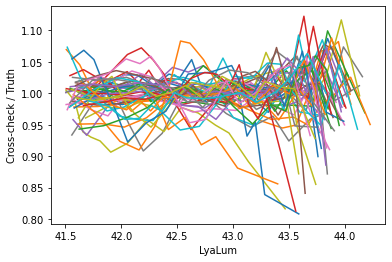

In [8]:
data_by_cc = LF_ccheck.build_mocked_model_values_original_independent()

for i in range(n_models_crosschecks):
    unique_identifier = first[i]
    cc_over_og = data_by_cc[unique_identifier]["dependent"] / model_values_crosschecks[unique_identifier]["dependent"]
    plt.plot(data_by_cc[unique_identifier]["independent"],cc_over_og)
    plt.xlabel("LyaLum")
    plt.ylabel("Cross-check / Truth")
#     plt.ylim((0,2))
plt.savefig("5d_figures_5.5_new/cross_check_accuracy.png",dpi=200)
plt.show()

# plt.savefig("Cross_check_accuracy.png",dpi=200)

/home/claraxu/anaconda3/lib/python3.8/site-packages/swiftemulator/sensitivity/cross_check.py:241: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


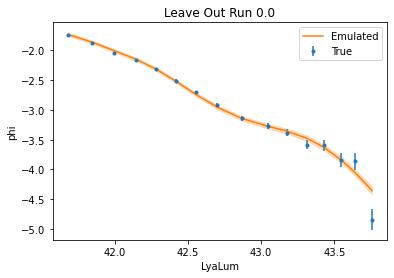

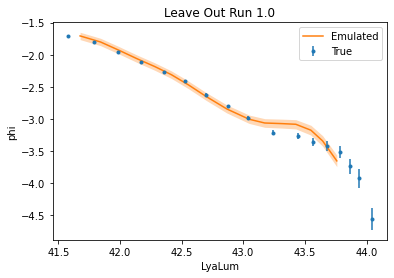

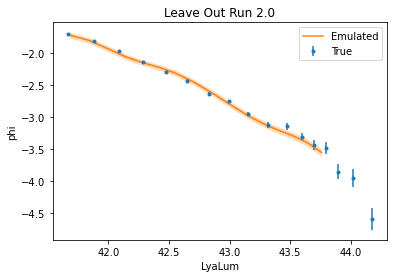

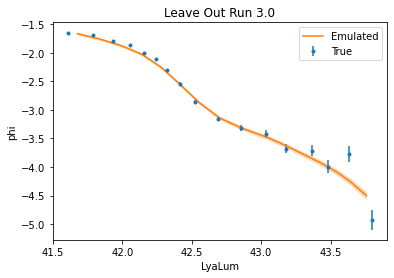

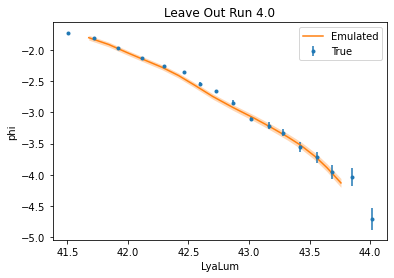

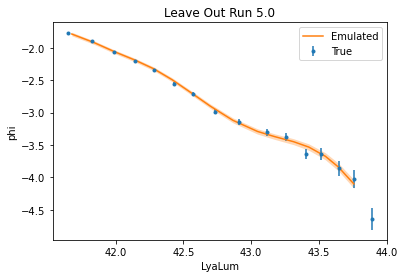

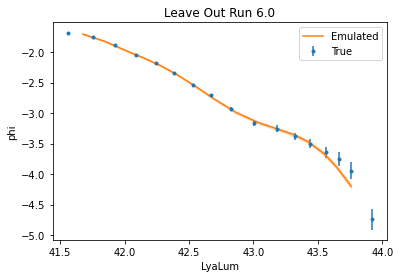

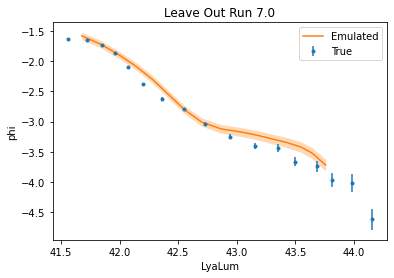

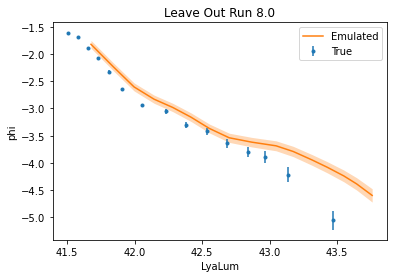

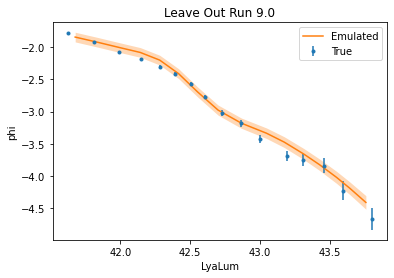

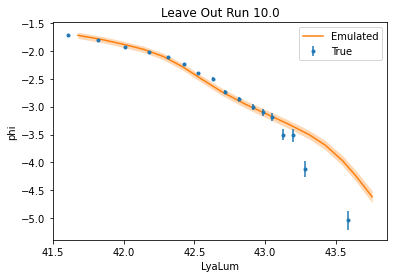

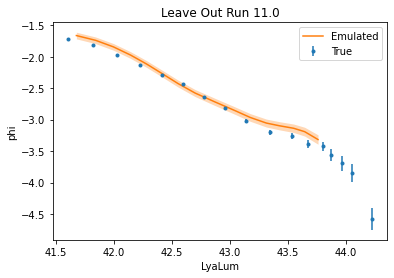

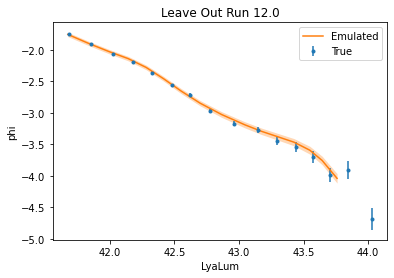

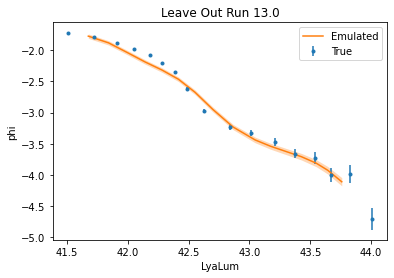

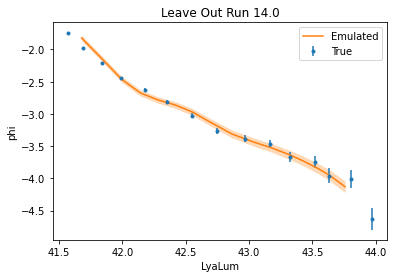

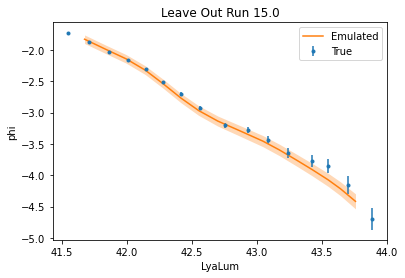

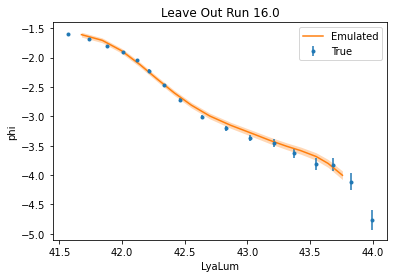

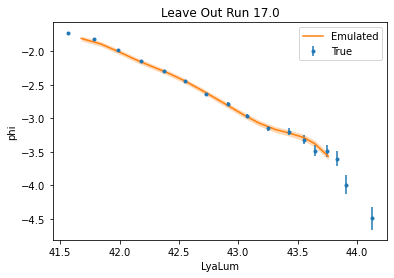

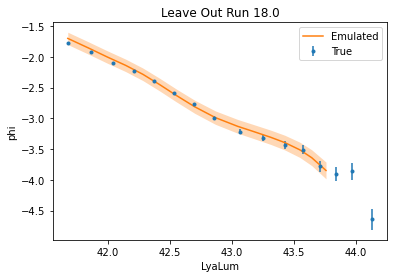

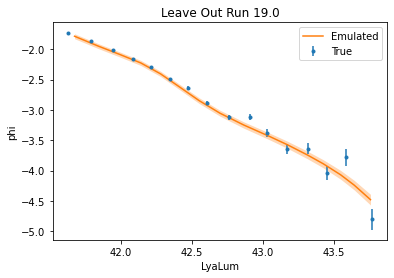

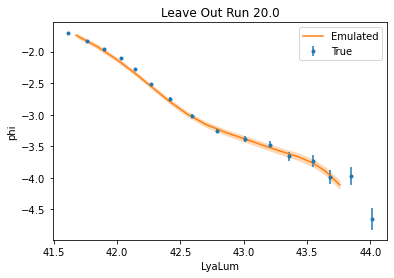

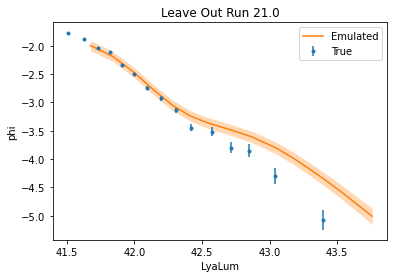

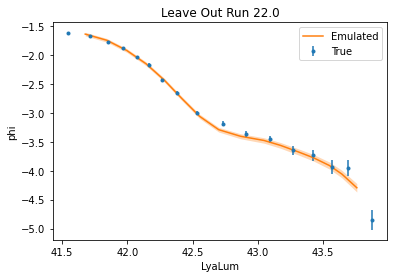

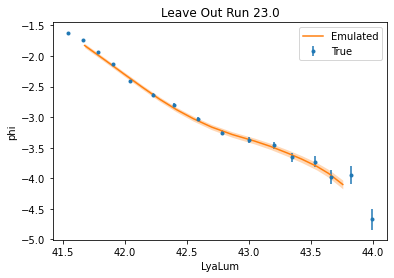

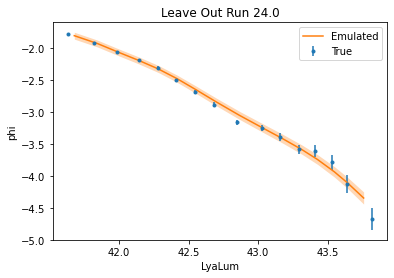

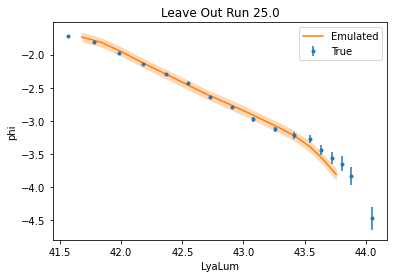

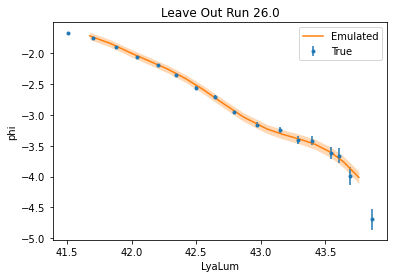

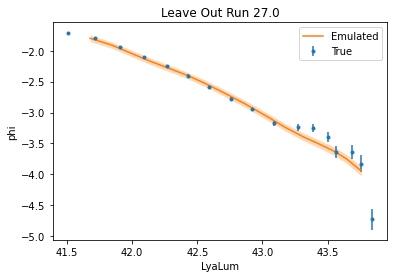

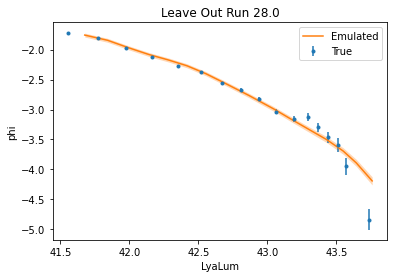

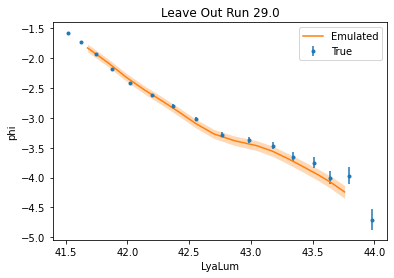

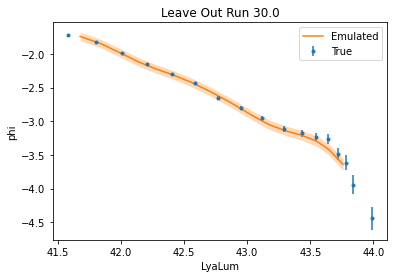

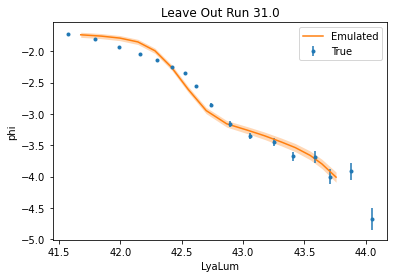

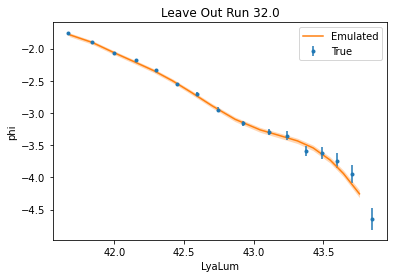

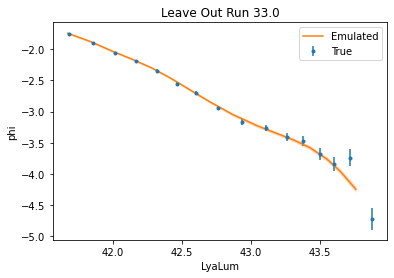

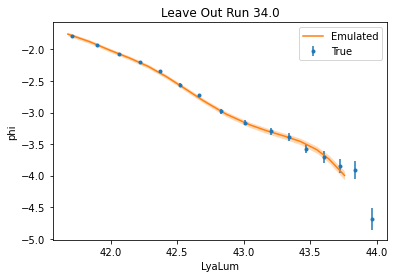

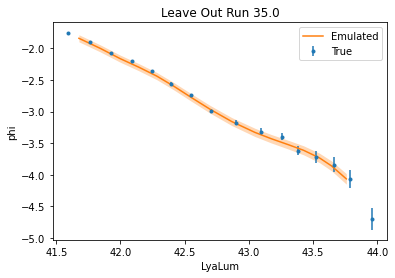

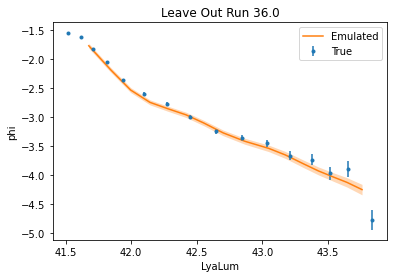

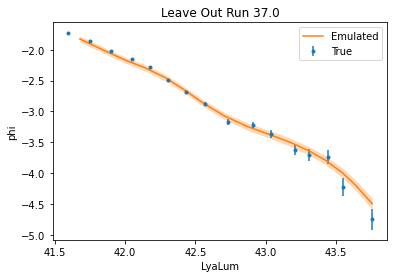

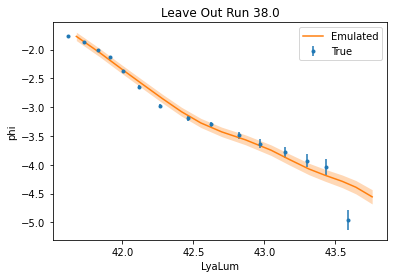

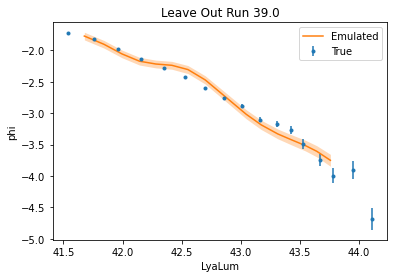

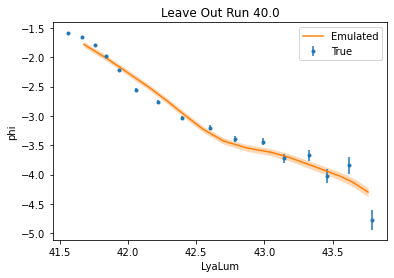

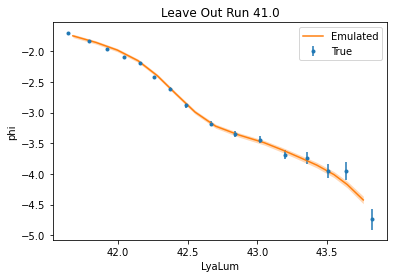

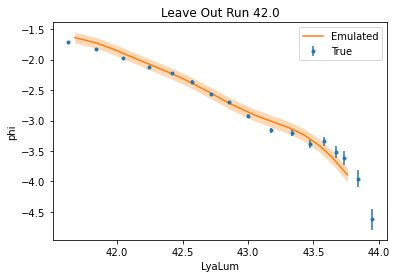

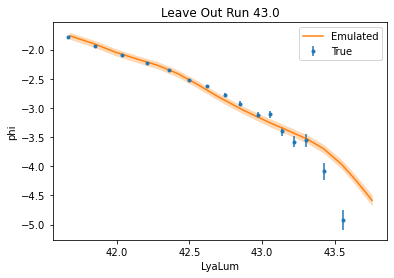

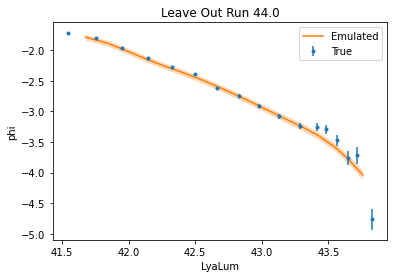

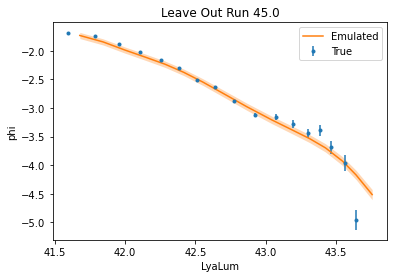

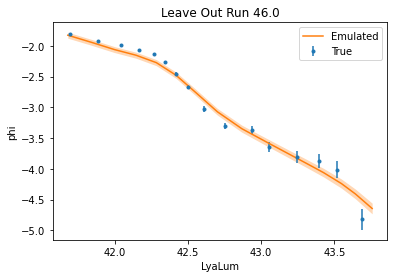

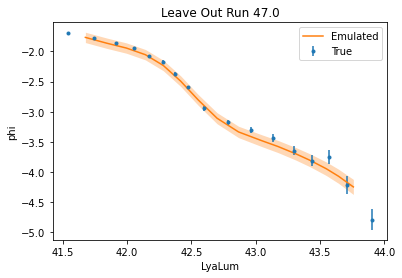

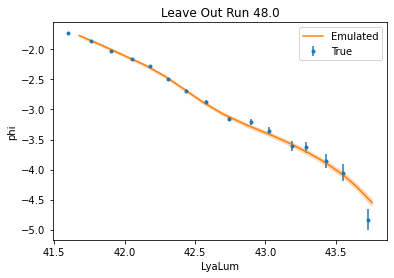

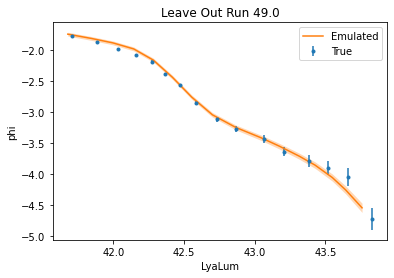

In [13]:
predict_x = model_values[0]['independent']
mask = predict_x > 41.5
predict_x = predict_x[mask]

LF_ccheck.plot_results(predict_x, './5d_figures_5.5_new', 'LyaLum', 'phi')

### Linear model

In [20]:
from swiftemulator.emulators import linear_model

LF_linear = linear_model.LinearModelEmulator()
LF_linear.fit_model(model_specification=model_specification, model_parameters=model_parameters, model_values=model_values)

LF_linear_obj = open('LF_linear_5d_5.5_new.obj', 'wb')
pickle.dump(LF_linear, LF_linear_obj)
LF_linear_obj.close()


In [14]:
# unpickle
LF_linear_obj = open('LF_linear_5d_5.5_new.obj', 'rb')
LF_linear = pickle.load(LF_linear_obj)
LF_linear_obj.close()

<ipython-input-15-28b877d84796>:6: RuntimeWarning: divide by zero encountered in log10
  predict_x = np.log10(f['y_avg_obs'][:].astype(np.float64))
<ipython-input-15-28b877d84796>:9: RuntimeWarning: divide by zero encountered in log10
  log_yerr = 0.5 * (np.log10(y_phi_obs + y_err_obs) - np.log10(y_phi_obs - y_err_obs))
<ipython-input-15-28b877d84796>:9: RuntimeWarning: invalid value encountered in subtract
  log_yerr = 0.5 * (np.log10(y_phi_obs + y_err_obs) - np.log10(y_phi_obs - y_err_obs))
<ipython-input-15-28b877d84796>:12: RuntimeWarning: divide by zero encountered in log10
  log_y = np.log10(f['y_phi_obs'][:])


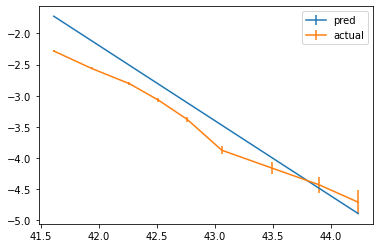

In [15]:
predictparams = {"log_Mhalo_min": 9.5,"log_Mhalo_max": 12, "fesc_min": 0.1, 'a_mu': 1.5, 'b_mu': 1}

# slight issue: no real run outside training set for snap 60 but oh well
filename = '/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/LF/LF_M7_0_054.hdf5'
with h5py.File(filename, 'r') as f:
    predict_x = np.log10(f['y_avg_obs'][:].astype(np.float64))
    y_phi_obs = f['y_phi_obs'][:].astype(np.float64)
    y_err_obs = f['y_err_obs'][:].astype(np.float64)
    log_yerr = 0.5 * (np.log10(y_phi_obs + y_err_obs) - np.log10(y_phi_obs - y_err_obs))
    mask = predict_x > 41.5
    predict_x = predict_x[mask]
    log_y = np.log10(f['y_phi_obs'][:])
    log_y = log_y[mask]
    log_yerr = log_yerr[mask]
    
# print(predict_x)

pred, pred_var = LF_linear.predict_values(predict_x, predictparams)

plt.errorbar(predict_x,pred, np.sqrt(pred_var), label='pred')
plt.errorbar(predict_x,log_y, log_yerr, label='actual')
plt.legend()
plt.savefig("5d_figures_5.5_new/linear_comparison.png",dpi=200)
plt.show()

### Penalty functions

In [5]:
# unpickle emulator
LF_emulator_obj = open('LF_emulator_5d_5.5_new.obj', 'rb')
LF_emulator = pickle.load(LF_emulator_obj)
LF_emulator_obj.close()

In [6]:
### observations ###
from velociraptor.observations.objects import ObservationalData
from unyt import Lsun, Mpc

# z = 5.7
santos_loglum = np.array([42.52, 42.72, 42.92, 43.12, 43.32, 43.52, 43.72])
santos_logphi = np.array([-2.63, -2.77, -3.15, -3.54, -3.91, -4.27, -5.12])
santos_phi = 10**santos_logphi
santos_loghighdiff = np.array([0.16, 0.12, 0.10, 0.08, 0.09, 0.11, 0.22])
santos_loglowdiff = np.array([0.17, 0.13, 0.10, 0.08, 0.10, 0.12, 0.40])
santos_loglow = santos_logphi-santos_loglowdiff
santos_low = 10**santos_loglow
santos_loghigh = santos_logphi+santos_loghighdiff
santos_high = 10**santos_loghigh
santos_lowdiff = santos_phi-santos_low
santos_highdiff = santos_high-santos_phi

# z = 5.7
konno_loglum = np.array([42.95, 43.05, 43.15, 43.25, 43.35, 43.45, 43.55, 43.65, 43.75])
konno_logphi = np.array([-3.478, -3.735, -3.953, -4.163, -4.427, -4.970, -5.170, -5.318, -5.717])
konno_phi = 10**konno_logphi
konno_loghighdiff = np.array([0.038, 0.044, 0.043, 0.055, 0.076, 0.147, 0.187, 0.224, 0.365])
konno_loglowdiff = np.array([0.193, 0.199, 0.198, 0.210, 0.231, 0.308, 0.355, 0.401, 0.606])
konno_loglow = konno_logphi-konno_loglowdiff
konno_low = 10**konno_loglow
konno_loghigh = konno_logphi+konno_loghighdiff
konno_high = 10**konno_loghigh
konno_lowdiff = konno_phi-konno_low
konno_highdiff = konno_high-konno_phi

# z = 5.7
ouchi_loglum = np.array([42.5000, 42.7000, 42.9000, 43.1000, 43.3000, 43.5000])
ouchi_phi = np.array([0.00196859, 0.00104739, 0.000461861, 0.000140703, 7.76078e-05, 2.21466e-05])
# test this
ouchi_lowdiff = np.array([0.000624648, 0.000354598, 0.000147644, 6.19600e-05, 4.23372e-05, 1.40073e-05])
ouchi_highdiff = np.array([0.00102783, 0.000562436, 0.000241909, 8.55829e-05, 5.29184e-05, 1.64491e-05])
ouchi_low = ouchi_phi-ouchi_lowdiff
ouchi_high = ouchi_phi+ouchi_highdiff

## uncorrected
# phi
phi_obs = np.concatenate((santos_phi, konno_phi, ouchi_phi))
log_phi_obs = np.log10(phi_obs)
# lum
log_L_obs = np.concatenate((santos_loglum, konno_loglum, ouchi_loglum))
# err
low_obs = np.concatenate((santos_low, konno_low, ouchi_low))
high_obs = np.concatenate((santos_high, konno_high, ouchi_high))
err_obs = (high_obs - low_obs) / 2.
log_low_obs = np.log10(low_obs)
log_high_obs = np.log10(high_obs)
log_lowdiff_obs = log_phi_obs - log_low_obs
log_highdiff_obs = log_high_obs - log_phi_obs
log_err_obs = (log_high_obs - log_low_obs) / 2.

# making sure observations are sorted by increasing luminosity
observations_dict = {}
for i in range(len(log_L_obs)):
    observations_dict[log_L_obs[i]] = [log_phi_obs[i], log_err_obs[i]]
log_L_obs_sorted = np.sort(log_L_obs)
log_phi_obs_sorted = np.zeros(len(log_phi_obs))
log_err_obs_sorted = np.zeros(len(log_err_obs))
for i in range(len(log_L_obs)):
    log_phi_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][0]
    log_err_obs_sorted[i] = observations_dict[log_L_obs_sorted[i]][1]

# fit schechter function
def schechter(log_M, log_phi, log_M0, alpha):
    log_M_diff = log_M - log_M0
    phi = 10**log_phi
    return phi * (10.0 ** ((alpha + 1.0) * (log_M_diff))) * np.exp(-(10.0 ** log_M_diff))

def log_schechter(log_M, log_phi, log_M0, alpha):
    return np.log10(schechter(log_M, log_phi, log_M0, alpha))

def schechter_fixalpha(log_M, log_phi, log_M0):
    alpha = -1.5
    log_M_diff = log_M - log_M0
    phi = 10**log_phi
    return phi * (10.0 ** ((alpha + 1.0) * (log_M_diff))) * np.exp(-(10.0 ** log_M_diff))

def log_schechter_fixalpha(log_M, log_phi, log_M0):
    return np.log10(schechter_fixalpha(log_M, log_phi, log_M0))

popt, pcov = curve_fit(
    log_schechter, log_L_obs_sorted, log_phi_obs_sorted, p0=(log_phi_obs_sorted[0], 42, -1.0), sigma=log_err_obs_sorted, absolute_sigma=True
)
print(popt)
log_phi_schechter_fit = log_schechter(log_L_obs_sorted, *popt)

# add units, make compatible with ObservationalData()
L_obs = 10 ** log_L_obs_sorted
L_obs *= Lsun
# phi_obs_filter = 10 ** log_phi_obs_filter
# phi_obs_filter *= Mpc**(-3)
# phi_linefit = 10 ** log_phi_linefit
# phi_linefit *= Mpc**(-3)
phi_schechter = 10 ** log_phi_schechter_fit
phi_schechter *= Mpc**(-3)

# uncorrected
observation = ObservationalData()
observation.associate_x(L_obs, scatter=None, comoving=False, description="Lya Luminosity")
# observation.associate_y(phi_obs_filter, scatter=None, comoving=False, description="phi (through a gaussian filter)")
observation.associate_y(phi_schechter, scatter=None, comoving=False, description="phi (fit to schechter function)")

[-3.99232899 43.45344399 -2.5340558 ]


[-2.98771556 43.01008413]


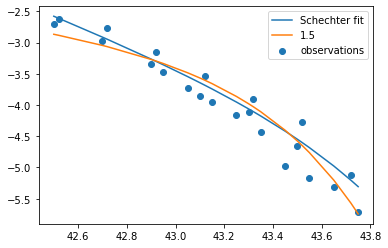

In [12]:
popt, pcov = curve_fit(
    log_schechter_fixalpha, log_L_obs_sorted, log_phi_obs_sorted, p0=(log_phi_obs_sorted[0], 42), sigma=log_err_obs_sorted, absolute_sigma=True
)
print(popt)
log_phi_schechter_fit_alpha = log_schechter_fixalpha(log_L_obs_sorted, *popt)

plt.scatter(log_L_obs_sorted, log_phi_obs_sorted, label='observations')
plt.plot(log_L_obs_sorted, log_phi_schechter_fit, label='Schechter fit')
plt.plot(log_L_obs_sorted, log_phi_schechter_fit_alpha, label='1.5')
plt.legend()
plt.savefig("5d_figures_5.5_new/schechter_fit_comparison.png",dpi=200)
plt.show()

#### Regular emulator

In [ ]:
from swiftemulator.mocking import mock_hypercube

pred_values, pred_params = mock_hypercube(LF_emulator, model_specification, 10000)

In [7]:
# unpickle
pred_values_obj = open('pred_values_5d_5.5_new.obj', 'rb')
pred_values = pickle.load(pred_values_obj)
pred_values_obj.close()

pred_params_obj = open('pred_params_5d.obj', 'rb')
pred_params = pickle.load(pred_params_obj)
pred_params_obj.close()

In [8]:
for i in range(len(pred_params)):
    pred_param = pred_params[f'emulated_{i}']
    log_Mhalo_min = pred_param['log_Mhalo_min']
    log_Mhalo_max = pred_param['log_Mhalo_max']
    if log_Mhalo_min > log_Mhalo_max:
        pred_params.model_parameters.pop(f'emulated_{i}')
        pred_values.model_values.pop(f'emulated_{i}')

In [19]:
print(len(pred_params))
print(len(pred_values))

41634
41634


/home/claraxu/anaconda3/lib/python3.8/site-packages/swiftemulator/comparison/penalty.py:241: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(xs, ys, output, vmin=0.0, vmax=1.0, rasterized=True)


Best fit node =  emulated_39662


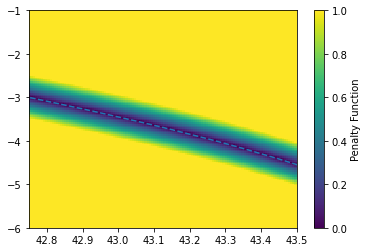

In [9]:
# L1
from swiftemulator.comparison.penalty import L1PenaltyCalculator

penalty = L1PenaltyCalculator(offset=0.5, lower=42.6, upper=43.6) # change offsets - still need to try this!
penalty.register_observation(observation, log_independent=True, log_dependent=True, independent_units=Lsun, dependent_units=Mpc**-3)
penalty.plot_penalty(42.75,43.5,-6,-1,"penalty_example")

all_penalties = penalty.penalties(pred_values, np.max) # try max
# print(all_penalties)

all_penalties_array = []
node_number = []
for key in all_penalties.keys():
    all_penalties_array.append(all_penalties[key])
    
    node_number.append(key)

print("Best fit node = ",node_number[np.argmin(all_penalties_array)])

best_fit_node = node_number[np.argmin(all_penalties_array)]

In [10]:
from scipy.spatial import cKDTree

n_params = 5
norm_params = np.zeros((len(pred_params), 5))
k = 0
key_dict = {}
for key in pred_params.model_parameters.keys():
    pred_param = pred_params[key]
    log_Mhalo_min = (pred_param['log_Mhalo_min'] - 9.5) / 2.
    log_Mhalo_max = (pred_param['log_Mhalo_max'] - 10.5) / 1.5
    fesc_min = (pred_param['fesc_min'] - 0.05) / 0.35
    a_mu = pred_param['a_mu'] / 2.
    b_mu = (pred_param['b_mu'] - 1.)
    
#     norm_params[k] = np.zeros(5)
    
    norm_params[k][0] = log_Mhalo_min
    norm_params[k][1] = log_Mhalo_max
    norm_params[k][2] = fesc_min
    norm_params[k][3] = a_mu
    norm_params[k][4] = b_mu
    
    key_dict[k] = key
    k += 1
    
tree = cKDTree(data=norm_params)

median_local_penalty = {}

for index in range(len(pred_params)):
    _, neighbours = tree.query(norm_params[index], k=32)

    neighbor_penalties = np.zeros(32)
    for i in range(32):
        key = key_dict[neighbours[i]]
        neighbor_penalties[i] = all_penalties[key]
    
    median_local_penalty[key_dict[index]] = np.median(neighbor_penalties)

best_key, best_value = min(median_local_penalty.items(), key=lambda x: x[1])

In [11]:
print(best_key)

emulated_43598


In [12]:
print(pred_params['emulated_43598'])

{'log_Mhalo_min': 10.467298963544206, 'log_Mhalo_max': 11.37641565318656, 'fesc_min': 0.10463668446949363, 'a_mu': 1.2175549129539622, 'b_mu': 1.4688566782805683}


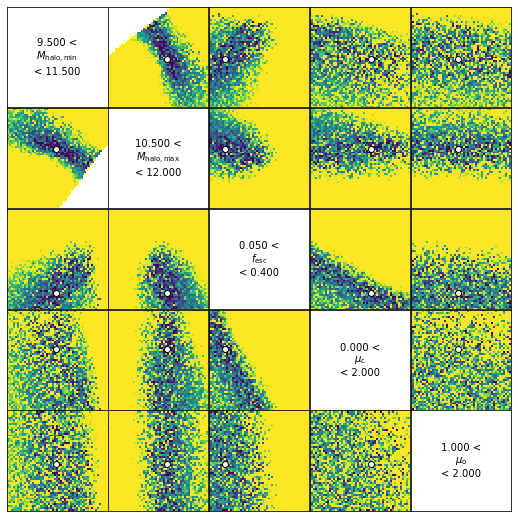

In [23]:
from swiftemulator.comparison.visualisation import visualise_penalties_generic_statistic

fig, ax = visualise_penalties_generic_statistic(model_specification=model_specification, model_parameters=pred_params,
                                      penalties=all_penalties, statistic='min', highlight_model=best_key
)

plt.savefig("5d_figures_5.5_new/penalty_plot.png",dpi=200)
plt.show()

In [13]:
from swiftemulator import ModelSpecification, ModelParameters
from matplotlib.pyplot import Normalize
from scipy.stats import binned_statistic_2d
from typing import Dict, Optional, Hashable, Iterable, Tuple

def visualise_penalties_generic_statistic(
    model_specification: ModelSpecification,
    model_parameters: ModelParameters,
    penalties: Dict[Hashable, float],
    good_penalty_threshold: float,
    number_of_bins: int,
    statistic: Optional[str] = None,
    norm_statistic: Normalize = Normalize(vmin=0.2, vmax=0.7, clip=True),
    norm_depth: Normalize = Normalize(vmin=0.0, vmax=0.4, clip=True),
#     norm_depth: Normalize = LogNorm(vmin=0.0, vmax=1.0, clip=True),
    cmap_statistic: str = "viridis",
    cmap_depth: str = "inferno",
    ticks_outside: bool = True,
    figsize: Optional[Tuple[float]] = None,
    use_parameters: Optional[Iterable[str]] = None,
    use_colorbar: Optional[bool] = False,
    highlight_model: Optional[Hashable] = None,
) -> Tuple[plt.Figure, Iterable[plt.Axes]]:
    """
    Visualises the penalties using basic binning.
    Parameters
    ----------
    model_specification: ModelSpecification
        The appropriate model specification. Used for the limits
        of the figure.
    model_parameters: ModelParameters
        Parameters of the model, with the appropriate unique IDs.
    penalties: Dict[Hashable, float]
        Penalties for all parameters in ``model_parameters``, with
        the key in this dictionary being the unique IDs.
    good_penalty_threshold: float
        The penalty below which models are considered 'good' and can
        contribute to the depth plot.
    number_of_bins: int
        The number of bins to use for an individual square plot,
        in one dimension.
    statistic: str, optional
        The statistic that you would like to compute. Allowed values
        are the same as for ``scipy.stats.binned_statistic_2d``.
        Defaults to ``mean``.
    norm_statistic: Normalize, optional
        A ``matplotlib`` normalisation object. By default this uses
        ``vmin=0.2`` and ``vmax=0.7``.
    norm_depth: Normalize, optional
        A ``matplotlib`` normalisation object. By default this uses
        ``vmin=0.2`` and ``vmax=0.7``.
    cmap_statistic: str, optional
        The color map to use for the statistic visualisation
    cmap_depth: str, optional
        The color map to use for the depth visualisation
    ticks_outside: bool, optional
        Include ticks on the outside?.
    figsize: Tuple[float], optional
        The figure size to use. Defaults to 7 inches by 7 inches, the
        size for a ``figure*`` in the MNRAS template.
    use_parameters: Iterable[str], optional
        The parameters to include in the figure. If not provided, all
        parameters in the ``model_specification`` are used.
    use_colorbar: Bool, optional
        Include a colorbar? Default: False.
    highlight_model: Hashable, optional
        The model unique ID to highlight. If not provided, no model is
        highlighted.
    Returns
    -------
    fig: Figure
        The figure object.
    axes: np.ndarray[Axes]
        The individual axes.
    Notes
    -----
    You can either change how the figure looks by using the figure
    and axes objects that are returned, or by modifying the
    ``matplotlib`` stylesheet you are currently using.
    """

    if use_parameters is None:
        use_parameters = model_specification.parameter_names

    if figsize is None:
#         if use_colorbar:
#             figsize = (7.0, 7.4)
#         else:
#             figsize = (7.0, 7.0)
        figsize = (7.0, 7.0)

    parameter_indices = [
        model_specification.parameter_names.index(x) for x in use_parameters
    ]

    number_of_parameters = len(use_parameters)
    grid_size = number_of_parameters

    fig, axes_grid = plt.subplots(
        grid_size,
        grid_size,
        figsize=figsize,
        squeeze=True,
        sharex="col",
        sharey="row",
    )

    visualisation_size = 4.0 / np.sqrt(len(model_parameters))
    simulation_ordering = list(model_parameters.keys())

    if highlight_model is not None:
        highlight_index = simulation_ordering.index(highlight_model)

    # Build temporary 1D arrays of parameters/offsets in correct ordering
    ordered_penalties = np.array([penalties[x] for x in simulation_ordering])
    good_model_mask = ordered_penalties < good_penalty_threshold

    limits = model_specification.parameter_limits

    # a thing that I (Clara) shall insert for the purposes of making plots look pretty. comment this out for other plots
    tick0 = [9.5, 10, 10.5, 11, 11.5]
    tick1 = [10.5, 11, 11.5, 12]
    tick2 = [0.1, 0.2, 0.3, 0.4]
    tick3 = [0, 0.5, 1, 1.5, 2]
    tick4 = [1, 1.25, 1.5, 1.75, 2]
    tickks = [tick0, tick1, tick2, tick3, tick4]
    
    label0 = ['', '10', '10.5', '11', '11.5']
    label1 = ['', '11', '11.5', '12']
    label2 = ['0.1', '0.2', '0.3', '0.4']
    label3 = ['', '0.5', '1', '1.5', '']
    label4 = ['1', '1.25', '1.5', '1.75', '2']
    ylabels = [label0, label1, label2, label3, label4]
    
    label0 = ['9.5', '10', '10.5', '11', '11.5']
    label1 = ['', '11', '11.5', '']
    label2 = ['0.1', '0.2', '0.3', '0.4']
    label3 = ['', '0.5', '1', '1.5', '2']
    label4 = ['', '1.25', '1.5', '1.75', '2']
    xlabels = [label0, label1, label2, label3, label4]
    # ok everything afterwards is general
    
    ordered_parameters = [
        np.array(
            [
                model_parameters.model_parameters[x][parameter]
                for x in simulation_ordering
            ]
        )
        for index, parameter in zip(parameter_indices, use_parameters)
    ]

    bins = number_of_bins # int(round(1.0 / number_of_bins))

    statistic = statistic if statistic is not None else "mean"

    # colorbar attempts
    ims = {}
    
    # JB: I am 100% confident in this loop and that we are looping
    # over the correct axes. Do not change this loop.
    for parameter_y, axes_column in zip(parameter_indices, axes_grid):
        for parameter_x, ax in zip(parameter_indices, axes_column):
            if (parameter_y == 0 and parameter_x == 1) or (parameter_x == 0 and parameter_y == 1):
                massx = np.linspace(10, 12, 5)
                massy = massx
                ax.plot(massx, massy, zorder=20, color='orangered')
            
            limits_x = model_specification.parameter_limits[parameter_x]
            limits_y = model_specification.parameter_limits[parameter_y]
            name_x = model_specification.parameter_printable_names[parameter_x]
            name_y = model_specification.parameter_printable_names[parameter_y]

            is_center_line = parameter_x == parameter_y
            do_not_plot = is_center_line

            if do_not_plot:
                ax.text(
                    0.5,
                    0.5,
                    f"{limits_x[0]} <\n{name_x}\n< {limits_x[1]}",
                    transform=ax.transAxes,
                    ha="center",
                    va="center",
                )
            else:
                if parameter_x > parameter_y:
                    bckgrnd = mpl.cm.get_cmap('viridis', 2)
                    ax.set_facecolor(bckgrnd(2))
                    # Your actual statistic
#                     print(ordered_penalties)
#                     print(ordered_parameters[parameter_x])
                    grid, xs, ys, _ = binned_statistic_2d(
                        x=ordered_parameters[parameter_x],
                        y=ordered_parameters[parameter_y],
                        values=ordered_penalties,
                        statistic=statistic,
                        bins=bins,
                    )
#                     print(xs)
                    im = ax.pcolormesh(
                        xs,
                        ys,
                        grid.T,
                        norm=norm_statistic,
                        cmap=cmap_statistic,
                        rasterized=True,
                    )
                    ims['penalty'] = im
                else:
                    ax.set_facecolor('k')
                    counts_total, xs, ys, _ = binned_statistic_2d(
                        x=ordered_parameters[parameter_x],
                        y=ordered_parameters[parameter_y],
                        values=ordered_penalties,
                        statistic="count",
                        bins=bins,
                    )
                    counts_good, xs, ys, _ = binned_statistic_2d(
                        x=ordered_parameters[parameter_x][good_model_mask],
                        y=ordered_parameters[parameter_y][good_model_mask],
                        values=ordered_penalties[good_model_mask],
                        statistic="count",
                        bins=bins,
                    )
#                     print(xs)
                    
                    good_penalty_ratio = counts_good / counts_total
#                     print(good_penalty_ratio)

                    im = ax.pcolormesh(
                        xs,
                        ys,
                        good_penalty_ratio.T,
                        norm=norm_depth,
                        cmap=cmap_depth,
                        rasterized=True,
                    )
                    ims['depth'] = im
    
                # Uncomment me if you don't believe the comment above
                # ax.text(0.5, 0.5, f"x={name_x}\ny={name_y}", transform=ax.transAxes, ha="center", va="center", color="white")

                if highlight_model is not None:
                    highlight_x = ordered_parameters[parameter_x][highlight_index]
                    highlight_y = ordered_parameters[parameter_y][highlight_index]

                    ax.scatter(
                        highlight_x,
                        highlight_y,
                        color="white",
                        edgecolor="black",
                    )

                ax.set_xlim(*limits_x)
                ax.set_ylim(*limits_y)

            if not ticks_outside and (parameter_x != 0 or parameter_y != 0):
                ax.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    left=False,
                    right=False,
                    top=False,
                    labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                )

#                 if is_center_line:
#                     ax.text(
#                         0.5,
#                         0.5,
#                         f"{limits_x[0]} <\n{name_x}tst\n< {limits_x[1]}",
#                         transform=ax.transAxes,
#                         ha="center",
#                         va="center",
#                         fontsize=15,
#                     )
            else:
                ax.set_xticks(tickks[parameter_x])
                ax.set_xticklabels(xlabels[parameter_x])
                ax.set_yticks(tickks[parameter_y])
                ax.set_yticklabels(ylabels[parameter_y])
                ax.set_xlabel(name_x)
                ax.set_ylabel(name_y)

            # Set square in data reference frame
            ax.set_aspect(1.0 / ax.get_data_ratio())

#     print(axes_grid)
    if use_colorbar:
        cax1 = fig.add_axes([1.02, 0.52, 0.07, .48])
        cax1.set_xticks([])
        cax1.set_yticks([])
        cax1.set_axis_off()
        cbar = fig.colorbar(
            ims['penalty'],
            ax=cax1,
            orientation="vertical",
            label=f"Combined penalty along LOS",
            fraction=1
        )
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        
        cax2 = fig.add_axes([1.02, 0, 0.07, .48])
        cax2.set_xticks([])
        cax2.set_yticks([])
        cax2.set_axis_off()
        fig.colorbar(
            ims['depth'],
            ax=cax2,
            orientation="vertical",
            label=f"Viable fraction of parameter space along LOS",
            fraction=1,
            ticks=[0,0.1,0.2,0.3,0.4]
        )

    for a in axes_grid[:-1, :].flat:
        a.set_xlabel(None)
    for a in axes_grid[:, 1:].flat:
        a.set_ylabel(None)

    # As of matplotlib 3.3.4, with a large number of sub-plots this hangs...
    if grid_size > 4:
        fig.constrained_layout = False
        fig.subplots_adjust(0, 0, 1, 1, 0.005, 0.005)

    return fig, axes_grid

<ipython-input-13-a4c72c385ca6>:228: RuntimeWarning: divide by zero encountered in true_divide
  good_penalty_ratio = counts_good / counts_total
<ipython-input-13-a4c72c385ca6>:228: RuntimeWarning: invalid value encountered in true_divide
  good_penalty_ratio = counts_good / counts_total


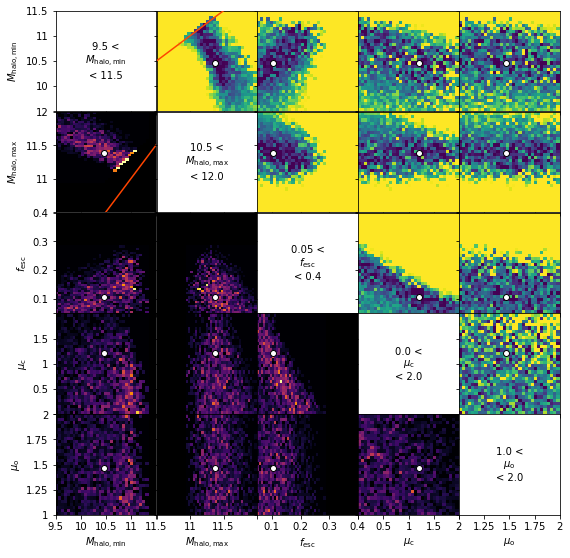

In [16]:
fig, ax = visualise_penalties_generic_statistic(model_specification=model_specification, model_parameters=pred_params,
                                                penalties=all_penalties, good_penalty_threshold=0.6,
                                                number_of_bins=32,
                                                statistic='min', highlight_model=best_key
)

plt.savefig("5d_figures_5.5_new/penalty_plot_depth_max.pdf",dpi=200)
plt.show()

In [26]:
# median penalty of close params
print(pred_params[best_key])

{'log_Mhalo_min': 10.467298963544206, 'log_Mhalo_max': 11.37641565318656, 'fesc_min': 0.10463668446949363, 'a_mu': 1.2175549129539622, 'b_mu': 1.4688566782805683}


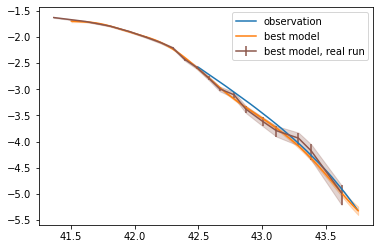

In [19]:
filename = f'/nfs/mvogelsblab001/Thesan/Thesan-1/postprocessing/tau/LF_bestfits/LF_5d_s0_080_new.hdf5'
with h5py.File(filename, 'r') as f: 
    y_avg = f['y_avg_obs'][:].astype(np.float64)
    y_phi = f['y_phi_obs'][:].astype(np.float64)
    y_err = f['y_err_obs'][:].astype(np.float64)
#     mask = (y_avg_gaussian_single > 1e39)
    y_avg = np.log10(y_avg)
#     y_phi = y_phi_gaussian_single[mask]
#     y_err = y_err_gaussian_single[mask]
    y_low = y_phi-y_err
    y_high = y_phi+y_err
    
    y_phi = np.log10(y_phi)
    y_low = np.log10(y_low)
    y_high = np.log10(y_high)
    
    y_lowdiff = y_phi - y_low
    y_highdiff = y_high - y_phi

best_model_parameters = pred_params[best_key]
pred_x = pred_values[best_key]['independent']
pred_y = pred_values[best_key]['dependent']
pred_err = np.sqrt(pred_values[best_key]['dependent_error'])
mask = pred_err < 0.08
pred_x = pred_x[mask]
pred_y = pred_y[mask]
pred_err = pred_err[mask]

plt.plot(log_L_obs_sorted, log_phi_schechter_fit, label='observation', c='C0')
plt.plot(pred_x, pred_y, label='best model', c='C1')
plt.fill_between(pred_x, pred_y+pred_err, pred_y-pred_err, color='C1', alpha=.25)

model_identifiers, closest_parameters = model_parameters.find_closest_model(best_model_parameters, 3)
# plt.plot(model_values[model_identifiers[0]]['independent'], model_values[model_identifiers[0]]['dependent'], label='closest model 1', color='C2')
# plt.fill_between(model_values[model_identifiers[0]]['independent'], model_values[model_identifiers[0]]['dependent']-3*model_values[model_identifiers[0]]['dependent_error'], model_values[model_identifiers[0]]['dependent']+3*model_values[model_identifiers[0]]['dependent_error'], color='C2', alpha=.25)
# plt.plot(model_values[model_identifiers[1]]['independent'], model_values[model_identifiers[1]]['dependent'], label='closest model 2', color='C3')
# plt.fill_between(model_values[model_identifiers[1]]['independent'], model_values[model_identifiers[1]]['dependent']-3*model_values[model_identifiers[1]]['dependent_error'], model_values[model_identifiers[1]]['dependent']+3*model_values[model_identifiers[1]]['dependent_error'], color='C3', alpha=.25)
# plt.plot(model_values[model_identifiers[2]]['independent'], model_values[model_identifiers[2]]['dependent'], label='closest model 3', color='C4')
# plt.fill_between(model_values[model_identifiers[2]]['independent'], model_values[model_identifiers[2]]['dependent']-3*model_values[model_identifiers[2]]['dependent_error'], model_values[model_identifiers[2]]['dependent']+3*model_values[model_identifiers[2]]['dependent_error'], color='C4', alpha=.25)

plt.errorbar(y_avg, y_phi, yerr=[y_lowdiff, y_highdiff], label='best model, real run', c='C5')
plt.fill_between(y_avg, y_low, y_high, color='C5', alpha=.25)

plt.legend()
plt.savefig("5d_figures_5.5_new/best_fit_comparison.png",dpi=200)
plt.show()


### idk hist stuff aka sweeps

In [9]:
def read_Lya(snap=70, sim='Thesan-1'):
    print(f'Reading snapshot {snap} ...')
    basePath = f'/nfs/mvogelsblab001/Thesan/{sim}/output'
    fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloVelDisp', 'SubhaloPos', 'SubhaloGrNr']
#     fields = ['SubhaloLenType', 'SubhaloMass', 'SubhaloMassInRadType', 'SubhaloStellarPhotometrics', 'SubhaloStarMetallicity']
#   'SubhaloSFRinRad', 'SubhaloCM', 'SubhaloPos', 'SubhaloVel', 'SubhaloVelDisp']
    s = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    Mpc = 1e6 * pc
    s['snap'] = snap
    s['basePath'] = basePath
    Lya_filename = basePath + f'/../postprocessing/Lya/Lya_{snap:03d}.hdf5'
    with h5py.File(Lya_filename, 'r') as f:
        g = f['Header']
        for key in ['BoxSize', 'EscapeFraction', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'HubbleParam', 'Time', 'Redshift']:
            s[key] = g.attrs[key]
#         BoxSize = g.attrs['BoxSize']
#         EscapeFraction = g.attrs['EscapeFraction']
#         Omega0 = g.attrs['Omega0']
#         OmegaBaryon = g.attrs['OmegaBaryon']
#         OmegaLambda = g.attrs['OmegaLambda']
        h = g.attrs['HubbleParam']
        a = g.attrs['Time']
        z = g.attrs['Redshift']
        UnitLength_in_cm = g.attrs['UnitLength_in_cm']
        UnitMass_in_g = g.attrs['UnitMass_in_g']
        UnitVelocity_in_cm_per_s = g.attrs['UnitVelocity_in_cm_per_s']
        UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
        UnitEnergy_in_cgs = UnitMass_in_g * UnitVelocity_in_cm_per_s * UnitVelocity_in_cm_per_s
        UnitLum_in_cgs = UnitEnergy_in_cgs / UnitTime_in_s
        length_to_cgs = a * UnitLength_in_cm / h
        length_to_kpc = length_to_cgs / kpc
        volume_to_cgs = length_to_cgs * length_to_cgs * length_to_cgs
        s['BoxSize_Mpc'] = s['BoxSize'] * length_to_cgs / Mpc # Box size in Mpc (physical)
        s['V_box_Mpc3'] = s['BoxSize_Mpc']**3 # Box volume in Mpc^3 (physical)
        s['V_box_cMpc3'] = s['V_box_Mpc3'] / s['Time']**3
        mass_to_cgs = UnitMass_in_g / h
        mass_to_Msun = mass_to_cgs / Msun
#         mask = (s['SubhaloLenType'][:,1] >= 0) # No masking
#         mask = ((s['SubhaloMassInRadType'][:,4] > 0. ) &
#                 (s['SubhaloLenType'][:,4] >= 4) &
#                 (s['SubhaloLenType'][:,1] >= 32)) # Minimally resolved
        s['SubhaloMass'] = mass_to_Msun * s['SubhaloMass'] # Msun
#         s['SubhaloMassInRadType'] = mass_to_Msun * s['SubhaloMassInRadType'] # Msun
#         s['SubhaloMassStars'] = mass_to_Msun * s['SubhaloMassInRadType'][:,4] # Msun
#         s['M1450'] = s['SubhaloStellarPhotometrics'][:,0]
        s['Lya'] = UnitLum_in_cgs * f['Subhalo']['LyaLum'][:].astype(np.float64) # Lya = LyaCol + LyaRec + LyaStars
        s['LyaCol'] = UnitLum_in_cgs * f['Subhalo']['LyaLumCol'][:].astype(np.float64) # erg/s
        s['LyaRec'] = UnitLum_in_cgs * f['Subhalo']['LyaLumRec'][:].astype(np.float64) # erg/s
        s['LyaStars'] = UnitLum_in_cgs * f['Subhalo']['LyaLumStars'][:].astype(np.float64) # erg/s
        s['L1216'] = UnitLum_in_cgs * f['Subhalo']['1216LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['L1500'] = UnitLum_in_cgs * f['Subhalo']['1500LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['L2500'] = UnitLum_in_cgs * f['Subhalo']['2500LumStars'][:].astype(np.float64) # erg/s/Angstrom
        s['IonAGN'] = UnitLum_in_cgs * f['Subhalo']['IonLumAGN'][:].astype(np.float64) # erg/s
        mask = (s['IonAGN'] > 0.)
        y_AGN = s['IonAGN'][mask] / E_AGN # AGN ionizing photon rate [photons/s]
        y_stars = s['LyaStars'][mask] / (0.68 * E_Lya * (1. - s['EscapeFraction'])) # Star ionizing photon rate [photons/s]
        s['f_AGN'] = y_AGN / (y_AGN + y_stars)
#         for key in ['SubhaloMass', 'SubhaloMassStars', 'Lya', 'LyaCol', 'LyaRec', 'LyaStars', 'L1216', 'L1500', 'L2500', 'IonAGN']:
#             if key == 'L1500':
#                 s['SubhaloStarMetallicity'] = s['SubhaloStarMetallicity'][s[key]>0.] / 0.0127 # Solar units
#             s[key] = s[key][s[key]>0.]
#         s['M1450'] = s['M1450'][s['M1450']<0.]
        s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
        s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
        s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude
        # Note: z = [6, 7, 8, 9, 10]  =>  dtm = [0.11, 0.08, 0.06, 0.0001, 0.00001]
#         tau_dust = 1.76e-21 * (1500./1500.)**1.1 * s['SubhaloStarMetallicity'] * (0.11/0.44) * 5e21 #*min(1, max(0, 0.5*(8-zs[isnap])))
#         s['M1500_dust'] = s['M1500'] - 2.5*np.log10(np.exp(-tau_dust))
#         s['LyaPos'] = length_to_kpc * f['Subhalo']['LyaPos'][:][mask,:].astype(np.float64) # kpc
#         s['LyaVel'] = f['Subhalo']['LyaVel'][:][mask,:].astype(np.float64) # km/s
        s['LyaVelDisp'] = f['Subhalo']['LyaVelDisp'][:][mask].astype(np.float64) # km/s
    return s

In [10]:
def calc_hist(data, n_0=7, n_max=50000, reverse=True, use_median=True, factor=1.75):
    y = np.sort(data)
    if reverse:
        y = y[::-1] # Start from high mass end
    n_y = len(y)
    n_c = n_i = n_0
    n_bins = 1
    while n_c < n_y:
        n_i = min(int(factor * n_i), n_max, n_y - n_c)
        n_c += n_i
        n_bins += 1
    y_edges = np.zeros(n_bins+1)
    y_avg = np.zeros(n_bins)
    y_num = np.zeros(n_bins)
    y_edges[1] = 0.5 * (y[n_0-1] + y[n_0])
    y_edges[0] = y[0] + (y[n_0-1] - y_edges[1])
    y_avg[0] = np.median(y[0:n_0]) if use_median else np.mean(y[0:n_0])
    y_num[0] = n_0
    if reverse:
        assert y[n_0-1] > y[n_0]
        assert y_edges[0] > y[0]
    else:
        assert y[n_0-1] < y[n_0]
        assert y_edges[0] < y[0]
    n_c = n_i = n_0
    i_bin = 1
    while n_c < n_y:
        n_i = min(int(factor * n_i), n_max, n_y - n_c)
        y_edges[i_bin] = 0.5 * (y[n_c-1] + y[n_c])
        y_avg[i_bin] = np.median(y[n_c:n_c+n_i]) if use_median else np.mean(y[n_c:n_c+n_i])
        y_num[i_bin] = n_i
        n_c += n_i
        i_bin += 1
    y_edges[-1] = y[-1]
#     if False:
#         y_edges[-2] = y_edges[-1]
#         y_avg[-2] = (y_avg[-2]*y_num[-2] + y_avg[-1]*y_num[-1]) / (y_num[-2] + y_num[-1])
#         y_num[-2] = y_num[-2] + y_num[-1]
#         y_edges = y_edges[:-1]
#         y_avg = y_avg[:-1]
#         y_num = y_num[:-1]
    dy = y_edges[1:] - y_edges[:-1]
    if reverse:
        dy = -dy
#     print(n_bins)
#     print(np.sum(y_num)-n_y)
    return y_avg, y_num/dy, np.sqrt(y_num)/dy

In [11]:
s = read_Lya(snap=80, sim='Thesan-1')
LyaLum = s['Lya']

Reading snapshot 80 ...


<ipython-input-9-28a850683b43>:64: RuntimeWarning: divide by zero encountered in log10
  s['M1216'] = -2.5 * np.log10(fnu_1216_fac * s['L1216']) - 48.6 # Continuum absolute magnitude
<ipython-input-9-28a850683b43>:65: RuntimeWarning: divide by zero encountered in log10
  s['M1500'] = -2.5 * np.log10(fnu_1500_fac * s['L1500']) - 48.6 # Continuum absolute magnitude
<ipython-input-9-28a850683b43>:66: RuntimeWarning: divide by zero encountered in log10
  s['M2500'] = -2.5 * np.log10(fnu_2500_fac * s['L2500']) - 48.6 # Continuum absolute magnitude


<ipython-input-12-b89e7384dfa4>:1: RuntimeWarning: divide by zero encountered in log10
  y_avg, y_phi, y_err = calc_hist(np.log10(s['Lya']), n_0=7, factor=1.5)
<ipython-input-10-6880cbeb6739>:42: RuntimeWarning: invalid value encountered in subtract
  dy = y_edges[1:] - y_edges[:-1]
<ipython-input-12-b89e7384dfa4>:5: RuntimeWarning: divide by zero encountered in log10
  y_avg = np.log10(y_avg)
<ipython-input-12-b89e7384dfa4>:6: RuntimeWarning: divide by zero encountered in log10
  y_low = np.log10(y_phi-y_err)
<ipython-input-12-b89e7384dfa4>:7: RuntimeWarning: divide by zero encountered in log10
  y_high = np.log10(y_phi+y_err)
<ipython-input-12-b89e7384dfa4>:8: RuntimeWarning: divide by zero encountered in log10
  y_phi = np.log10(y_phi)


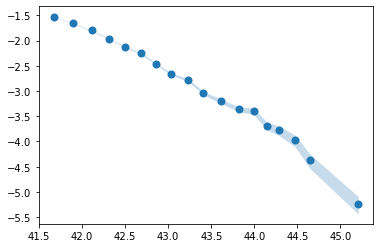

In [12]:
y_avg, y_phi, y_err = calc_hist(np.log10(s['Lya']), n_0=7, factor=1.5)
y_avg = y_avg[:-1]; y_phi = y_phi[:-1]; y_err = y_err[:-1]; # Remove tail
y_avg = 10.**y_avg; y_phi /= s['V_box_cMpc3']; y_err /= s['V_box_cMpc3']; # Volume normalization

y_avg = np.log10(y_avg)
y_low = np.log10(y_phi-y_err)
y_high = np.log10(y_phi+y_err)
y_phi = np.log10(y_phi)

mask = (y_avg > 41.5)
y_avg = y_avg[mask]
y_low = y_low[mask]
y_high = y_high[mask]
y_phi = y_phi[mask]

plt.fill_between(y_avg, y_low, y_high, lw=0., color='C0', alpha=.25)
plt.scatter(y_avg, y_phi, c='C0', lw=2.)

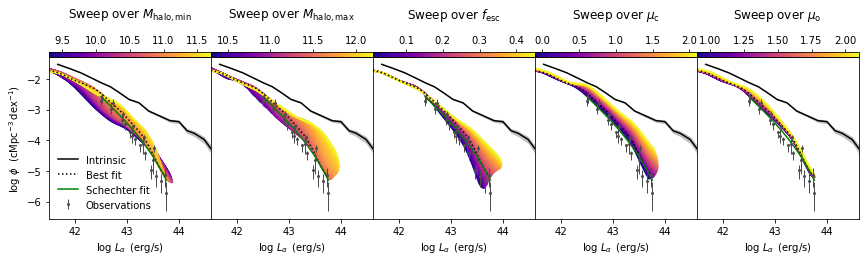

In [14]:
# sweeps: plot intrinsic thesan-1 black line, colorbar, horizontal, around best fit
# also observations with errors and schecter fit

from swiftemulator.mocking import mock_sweep

# combined center
combined_key = 'emulated_28391'
center = pred_params[combined_key]

pred_x = pred_values[combined_key]['independent']
pred_y = pred_values[combined_key]['dependent']
pred_err = np.sqrt(pred_values[combined_key]['dependent_error'])
mask = pred_err < 0.08
pred_x = pred_x[mask]
pred_y = pred_y[mask]
pred_err = pred_err[mask]

# z = 5.5 center
# center = pred_params[best_key]

n_params = 5
dax = 1.5
fax = 1.5 / float(n_params)
fig = plt.figure(figsize=(5.*dax,dax))

for j in range(n_params):
    ax = plt.axes([float(j)*fax,0.,fax,1.5])
#     ax = plt.axes([float(j)*fax,0.,fax,1.6])

    param_lims = model_specification.parameter_limits[j]
    param_min = param_lims[0]
    param_max = param_lims[1]
    
    n_sweeps = 50
    if j==1 or j==0:
        c = np.linspace(param_min-0.2,param_max+0.2,n_sweeps)
    elif j==2:
        c = np.linspace(param_min-0.04,param_max+0.05,n_sweeps)
    else:
        c = np.linspace(param_min-0.1,param_max+0.1,n_sweeps)

    norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
    cmap.set_array([])

    Mock_values, Mock_parameters = mock_sweep(LF_emulator,model_specification,n_sweeps,model_specification.parameter_names[j],center)

    # print(c)
    # print(cmap.to_rgba(c))

    for i in range(len(Mock_values.keys())):
        mock_name = list(Mock_values.keys())[i]
        mock_x = Mock_values[mock_name]["independent"]
        mock_y = Mock_values[mock_name]["dependent"]
        mock_err = np.sqrt(Mock_values[mock_name]["dependent_error"])
        mask = mock_err < 0.08
        mock_x = mock_x[mask]
        mock_y = mock_y[mask]
        mock_err = mock_err[mask]
        ax.plot(mock_x,
                mock_y,
    #             label = str(Mock_parameters[mock_name]["fesc_min"])[:4],
                color=cmap.to_rgba(c[i]))
    
    cax = fig.add_axes([float(j)*fax, 1.5, fax, .04])
    cbar = fig.colorbar(cmap, cax=cax, orientation='horizontal')
#     cbar.ax.xaxis.set_ticks(np.linspace(param_min, param_max, 11), minor=True)
#     cbar.ax.set_xticklabels([r'$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'])
#     cax.xaxis.set_minor_formatter(NullFormatter())
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
#     cax.tick_params(which='both', direction='in', labelsize=10.5)
#     cbar.set_label(r'$L_\alpha$', fontsize=12, labelpad=7)
    
#     fig.colorbar(cmap,location="top",pad=0.)

    ax.fill_between(y_avg, y_low, y_high, lw=0., color='k', alpha=.25)
    ax.plot(y_avg, y_phi, c='k', label='Intrinsic')
    
    ax.plot(pred_x, pred_y, label='Best fit', c='k', ls=':')
    
    ax.plot(log_L_obs_sorted, log_phi_schechter_fit, label='Schechter fit', c='green')
    
    kwargs = {'ms':2, 'elinewidth':1., 'lw':0., 'color':[.3,.3,.3], 'zorder':20, 'alpha':1.}
    ax.errorbar(log_L_obs, log_phi_obs, [log_lowdiff_obs, log_highdiff_obs], **kwargs, marker='o',label='Observations')
    if j==0:
        ax.legend(frameon=False)
        ax.set_ylabel(r'log $\phi\ \ (\rm{cMpc}^{-3}\,\rm{dex}^{-1})$')
    if j!=0:
        ax.set_yticks([])
    ax.set_xlim([41.5, 44.6])
    ax.set_xlabel(r'log $L_{\alpha}\ \,(\rm{erg/s})$')
    ax.set_title('Sweep over ' + model_specification.parameter_printable_names[j], y=1.2)
    
fig.savefig("5d_figures_5.5_new/fancysweep.pdf",bbox_inches='tight', transparent=True, dpi=300, pad_inches=0.025)
plt.show()